# **Composición mensual de la demanda eléctrica, precio monómico y emisiones por GWh generado**


---


El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos mensuales de la demanda eléctrica, el precio monómico de generación y las emisiones de dióxido de carbono (CO<sub>2</sub>), relevados por la Compañía Administradora del Mercado Mayorista Eléctrico Sociedad Anónima (CAMMESA).

El estudio de la evolución de la demanda eléctrica, y -en particular- de su composición, permite extraer conclusiones sobre los niveles de actividad económica. El precio monómico, en tanto, es fundamental para comprender el costo real de generación eléctrica. Por último, la cantidad de dióxido de carbono emitido por GWh generado brinda una medida de la eficiencia de la matriz energética.

Como resultado del análisis de datos, se presentan tres figuras: 


*   Para el estudio de la composición mensual de la demanda eléctrica, se presenta un gráfico de áreas apiladas, que permite visualizar claramente las participaciones de cada tipo de usuario.
*   Para el estudio del precio monómico, se presenta un gráfico de líneas, que muestra su evolución nominal.
*   Para el estudio de las emisiones, se presenta un gráfico de líneas, que muestra su evolución en toneladas de CO<sub>2</sub> por GWh generado.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import requests
import zipfile
import io
import plotly.graph_objects as go
import plotly.io as pio
import datetime as dt
from datetime import date

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.4 MB/s eta 0:00:00


## Obtención y limpieza de datos

La Compañía Administradora del Mercado Mayorista Eléctrico Sociedad Anónima (CAMMESA) publica informes mensuales (Informe Síntesis Mensual del MEM) en los que se resume la información de cada mes.

### General

Ante la falta de una serie histórica de las variables a utilizar, se deben utilizar las "bases" de los informes mensuales. Particularmente, se precisará las bases de los años definidos en la lista `years`.

In [3]:
years = [2017, 2020, 2021]

Cada uno de estos archivos contiene, asimismo, un número de identificación, definido en la lista `identifiers`.

In [4]:
identifiers = ["36502", "39195", "41598"]

Para acceder a dichos archivos, se crea una lista de links (`urls`) que remite a cada archivo.

In [5]:
urls = []
for year, identifier in zip(years, identifiers):
  if year != 2021:
    url = f"https://cammesaweb.cammesa.com/download/base_informe_mensual-{year}-12/?wpdmdl={identifier}"
    urls.append(url)
  else:
    url = f"https://cammesaweb.cammesa.com/download/base_informe_mensual_{year}-12/?wpdmdl={identifier}"
    urls.append(url)

Los archivos ya mencionados son publicados en forma de varios archivos `.xlsx` (Excel) que se encuentra dentro de un archivo `.zip`. Dado que la *library* `pandas` no lee archivos `.zip` directamente, se itera sobre cada link en `urls` para -mediante las *libraries* `request` e `io`- extraer los archivos guardados "dentro" del archivo `.zip` y guardarlos en la memoria de la interfaz.

In [6]:
for url in urls:
  request = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(request.content))
  z.extractall()

De todos los archivos extraídos, algunos son particularmente relevantes para el análisis:
1.   `BASE_INFORME_MENSUAL_2017-12.xlsx` contiene la base total a fecha de diciembre del año de 2017.
2.   `BASE_DEMANDA_INFORME_MENSUAL_2020-12.xlsx` contiene la base de demanda a fecha de diciembre del año de 2020.
3.   `BASE_OFERTA_INFORME_MENSUAL_2020-12.xlsx` contiene la base de oferta a fecha de diciembre del año de 2020.
4.   `BASE_DEMANDA_INFORME_MENSUAL_2021-12.xlsx` contiene la base de demanda a fecha de diciembre del año de 2021.

En particular, los archivos 1., 2. y 4. contienen los datos necesarios para el armado de las series históricas precisadas para la demanda y para el precio monómico. El archivo 3., en tanto, contiene los datos necesarios para el estudio de las emisiones de CO<sup>2</sup>.

Las cadenas de texto `path_base_2017`, `path_base_demanda_2020`, `path_base_oferta_2020` y `path_base_demanda_2021` contienen las rutas de acceso (`path`) a cada uno de estos archivos.

In [7]:
path_base_2017 = "/content/BASE_INFORME_MENSUAL_2017-12.xlsx"

In [8]:
path_base_demanda_2020 = "/content/BASE_DEMANDA_INFORME_MENSUAL_2020-12.xlsx"

In [9]:
path_base_oferta_2020 = "/content/BASE_OFERTA_INFORME_MENSUAL_2020-12.xlsx"

In [10]:
path_base_demanda_2021 = "/content/BASE_DEMANDA_INFORME_MENSUAL_2021-12.xlsx"

Sin embargo, los formatos de los archivos extraidos son muy diversos. Por tanto, se requiere especificar algunas de las posibles columnas deseadas en cada tipo de archivo.

De esta manera, las listas `cols`, `cols_mas_5` y `cols_precio` brindan alternativas de qué columnas utilizar.

In [11]:
cols = ["Período", "Demanda Residencial", "Demanda Comercial", "Gran Demanda Industrial/Comercial", "Demanda local"]
cols_nrows_no_5 = ["Período", "Demanda Residencial", "Demanda Comercial", "Gran Usuario en Distribuidor", "Gran Usuario MEM", "Gran Demanda Industrial/Comercial", "Demanda local"]
cols_precio = ["Período", "Precio monómico"]

Una vez identificados los puntos "en común" de los archivos deseados, la función `transform_df` permite leerlos y *homogeneizarlos*.

Los parámetros de la función son:

*   `df`: el nombre de cada `pd.DataFrame()` sobre el cual se leerá y escribirá cada archivo.
*   `path`: la ruta de acceso del archivo en el explorador de archivos de Google Colaboratory.
*   `sheetname`: el nombre de la hoja a leer.
*   `n_skiprows`: cantidad de filas iniciales a ignorar.
*   `n_nrows`: cantidad de filas totales a leer.
*   `min` y `max`: indicadores de filas sobre los que se *cortará* el *DataFrame*. Las filas menores a `min` y mayores a `max` serán eliminadas.

In [12]:
def transform_df(df, path, sheetname, n_skiprows, n_nrows, min, max):
  df = pd.read_excel(path, sheet_name=sheetname, skiprows=n_skiprows, nrows=n_nrows).T.reset_index(drop=True)
  df.rename(columns=df.iloc[0], inplace = True)
  df = df.drop(0).reset_index(drop=True)
  df = df[min:max]
  if sheetname == "DEMANDA":
    if n_nrows == 5:
      df.columns = cols
    else:
      df.columns = cols_nrows_no_5
  elif sheetname == "PRECIOS":
    df = df[[df.columns[0]] + [df.columns[12]]]
    df.columns = cols_precio
    df = df[1::]
  elif sheetname == "GENERACION":
    df = df[[df.columns[0]] + [df.columns[5]]]
  return df

### Demanda eléctrica

Como fuera dicho anteriormente, la falta de publicación de una serie histórica completa genera que se deban tratar con múltiples archivos a la vez.

El análisis comprende todos los meses desde enero del año 2013 a la fecha. En este sentido, se trabajará con 4 archivos diferentes:


1.   Enero 2013 a diciembre 2016: `BASE_INFORME_MENSUAL_2017-12.xlsx`, cuya ruta de acceso es `path_base_2017`.
2.   Enero 2017 a diciembre 2017: `BASE_DEMANDA_INFORME_MENSUAL_2020-12.xlsx`, cuya ruta de acceso es `path_base_demanda_2020`.
3.   Enero 2018 a diciembre 2019: `BASE_DEMANDA_INFORME_MENSUAL_2021-12.xlsx`, cuya ruta de acceso es `path_base_demanda_2021`.
4.   Enero 2020 a la actualidad: último Informe mensual de demanda, cuya ruta de acceso será definida oportunamente como `last_demanda`.

Se crea el *DataFrame* `demanda_2013_2016` y se le aplica la función `transform_df` con los parámetros correspondientes. Se utiliza `path_base_2017` dado que refiere a la base mensual de diciembre del año 2017.

`demanda_2013_2016`, como su nombre lo indica, contendrá la evolución de la demanda para el primer período (enero 2013 a diciembre 2016).

In [13]:
demanda_2013_2016 = pd.DataFrame()
demanda_2013_2016 = transform_df(demanda_2013_2016, path_base_2017, "DEMANDA", 3, 5, 0, 48)

Al igual que anteriormente, se crea el *DataFrame* `demanda_2017` y se le aplica la función `transform_df` con los parámetros correspondientes. Se utiliza `path_base_demanda_2020` refiriendo a la base mensual de diciembre del año 2020. El *DataFrame* contendrá la evolución de la demanda para el segundo período (enero 2017 a diciembre 2017).

In [14]:
demanda_2017 = pd.DataFrame()
demanda_2017 = transform_df(demanda_2017, path_base_demanda_2020, "DEMANDA", 3, 5, 0, 12)

El *DataFrame* `demanda_2018_2019` contiene la evolución de la demanda durante el tercer período (enero 2018 a diciembre 2019). Se utiliza `path_base_demanda_2021` dado que refiere a la base mensual de diciembre del año 2021.

In [15]:
demanda_2018_2019 = pd.DataFrame()
demanda_2018_2019 = transform_df(demanda_2018_2019, path_base_demanda_2021, "DEMANDA", 3, 7, 0, 24)

Se eliminan algunas columnas innecesarias en `demanda_2018`.

In [16]:
demanda_2018_2019 = demanda_2018_2019.drop([demanda_2018_2019.columns[3], demanda_2018_2019.columns[4]], axis=1)

Para el cuarto y último período, el `path` toma la forma de un link de descarga (`last_demanda`) a la página oficial de CAMMESA, dado que se utiliza la última versión disponible del Informe de Demanda Mensual.

In [17]:
last_demanda = "https://cammesaweb.cammesa.com/download/demanda-mensual/?wpdmdl=41426"

Es creado y actualizado el *DataFrame* `demanda_2020_act`.

In [18]:
demanda_2020_act = pd.DataFrame()
demanda_2020_act = transform_df(demanda_2020_act, last_demanda, "DEMANDA", 3, 7, None, None)

Nuevamente, se eliminan algunas columnas innecesarias en `demanda_2020_act`.

In [19]:
demanda_2020_act = demanda_2020_act.drop([demanda_2020_act.columns[3], demanda_2020_act.columns[4]], axis=1)

#### *DataFrame* final

Todos los *DataFrames* anteriores son unidos (`pd.concat()`) en un solo *DataFrame* llamado `demanda`, que contiene la serie histórica de la composición de demanda desde enero del año 2013.

In [20]:
demanda = pd.concat([
    demanda_2013_2016,
    demanda_2017,
    demanda_2018_2019,
    demanda_2020_act]).reset_index(drop=True)

Un valor de la columna "Período" (fila 70) era erróneo. Se lo modifica manualmente.

In [21]:
demanda["Período"][70] = pd.to_datetime((demanda["Período"][70] - 25569) * 86400.0, unit='s')

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [22]:
demanda.head()

,Período,Demanda Residencial,Demanda Comercial,Gran Demanda Industrial/Comercial,Demanda local
0,2013-01-01 00:00:00,4538446.146,3319300.732,3276372.467,11134119.345
1,2013-02-01 00:00:00,3961686.119,2820263.212,3052210.676,9834160.007
2,2013-03-01 00:00:00,3612835.111,2861328.931,3281965.266,9756129.308
3,2013-04-01 00:00:00,3239380.702,2826797.31,3241156.151,9307334.163
4,2013-05-01 00:00:00,3919668.996,2948663.278,3364493.12,10232825.394


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [23]:
demanda.to_excel("Demanda eléctrica por tipo de usuario.xlsx", index=False)

### Precio monómico

Una situación similar se evidencia en el caso de los precios monómicos: se deben examinar múltiples archivos a la vez. 

Sin embargo, contrariamente al caso de la demanda eléctrica, para conformar la serie histórica desde enero del año 2013 a la fecha solo se precisarán dos archivos:

1.   Enero 2013 a diciembre 2015: `BASE_INFORME_MENSUAL_2017-12.xlsx`, cuya ruta de acceso es `path_base_2017`.
2.   Enero 2016 a la actualidad: último informe de Precio Monómico Medio y Precio Estacional disponible, cuya ruta de acceso será definida oportunamente como `last_precios`.

En este sentido, nótese que el archivo `BASE_INFORME_MENSUAL_2017-12.xlsx` es el mismo que aquel utilizado en el caso de la demanda eléctrica (y notado en `path_base_2017`): mientras antes se utilizaba la hoja "DEMANDA", ahora se utiliza la hoja "PRECIOS".

Se crea el *DataFrame* `precios_2013_2015` y se le aplica la función `transform_df` con los parámetros correspondientes.

In [24]:
precio_2013_2015 = pd.DataFrame()
precio_2013_2015 = transform_df(precio_2013_2015, path_base_2017, "PRECIOS", 3, 17, 0, 37)

Para el segundo (y último) período, al igual que en el caso de la demanda eléctrica, el `path` toma la forma de un link de descarga (`last_precios`),  utilizándose la última versión disponible del Informe de Precio Monómico Medio y Precio Estacional.

In [25]:
last_precios = "https://cammesaweb.cammesa.com/download/precios-mensuales/?wpdmdl=41446"

Se crea y transforma el *DataFrame* `precios_2016_2023`.

In [26]:
precio_2016_act = pd.DataFrame()
precio_2016_act = transform_df(precio_2016_act, last_precios, "PRECIOS", 3, 17, None, None)

#### *DataFrame* final

Todos los *DataFrames* anteriores son unidos (`pd.concat()`) en un solo *DataFrame* llamado `precio`, que contiene la serie histórica del precio monómico desde enero del año 2013.

In [27]:
precio = pd.concat([
    precio_2013_2015,
    precio_2016_act]).reset_index(drop=True)

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [28]:
precio.head()

,Período,Precio monómico
0,2013-01-01 00:00:00,245.771936
1,2013-02-01 00:00:00,283.430338
2,2013-03-01 00:00:00,293.989551
3,2013-04-01 00:00:00,313.927175
4,2013-05-01 00:00:00,470.561839


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [29]:
precio.to_excel("Precio monómico.xlsx", index=False)

### Emisiones de CO<sub>2</sub> por GWh generado

El estudio de las emisiones de dióxido de carbono (en toneladas por GWh generado) se desarrolla trimestralmente, tomando como punto de partida el primer trimestre del año 2017.

#### Consumo mensual de combustibles

Primeramente, es necesario obtener los datos correspondientes al consumo de combustibles total desde 2017. Así, se precisan dos archivos:
1.   Enero 2017 a diciembre 2019: `BASE_OFERTA_INFORME_MENSUAL_2020-12.xlsx`, cuya ruta de acceso es `path_base_oferta_2020`.
2.   Enero 2020 a la actualidad: último informe de Consumo mensual de Combustibles, cuya ruta de acceso será definida oportunamente como `last_combustibles`.

Se crea el *DataFrame* `combustibles_2017_2019` y se le aplica la función `transform_df` con los parámetros correspondientes.

In [30]:
combustibles_2017_2019 = pd.DataFrame()
combustibles_2017_2019 = transform_df(combustibles_2017_2019, path_base_oferta_2020, "COMBUSTIBLES", 3, 5, 0, 36)

Para el segundo (y último) período, el `path` toma la forma de un link de descarga (`last_combustibles`),  utilizándose la última versión disponible del informe de Consumo mensual de Combustibles.

In [31]:
last_combustibles = "https://cammesaweb.cammesa.com/download/combustibles-mensual/?wpdmdl=41416"

Se crea y transforma el *DataFrame* `combustibles_2020_act`.

In [32]:
combustibles_2020_act = pd.DataFrame()
combustibles_2020_act = transform_df(combustibles_2020_act, last_combustibles, "COMBUSTIBLES", 3, 5, None, None)

##### *DataFrame* final

Todos los *DataFrames* anteriores son unidos (`pd.concat()`) en un solo *DataFrame* llamado `combustibles`, que contiene la serie histórica del consumo de combustiblesdesde enero del año 2017.

In [33]:
combustibles = pd.concat([
    combustibles_2017_2019,
    combustibles_2020_act]).reset_index(drop=True)

Se renombra la columna del índice temporal.

In [34]:
combustibles = combustibles.rename(columns={"TIPO": "Período"})

El cómputo de las emisiones de dióxido de carbono (CO<sub>2</sub>) por GWh generado se elabora a partir de la definición de factores de emisión, uno por cada tipo de combustible examinado en el *DataFrame* `combustibles`. Los factores de emisión son agrupados en la lista `factores_emision`.

In [35]:
f_emision_GN = 1.936
f_emision_FO = 3.127
f_emision_GO = 3.186
f_emision_CM = 2.441

In [36]:
factores_emision = [f_emision_GN, f_emision_FO, f_emision_GO, f_emision_CM]

Cada valor del *DataFrame* se multiplica por el factor de emisión correspondiente a cada fuente de combustible.

In [37]:
for column, f_emision in zip(combustibles.columns[1:], factores_emision):
  combustibles[column] = combustibles[column] * f_emision

Se crea la columna "Emisiones", que suma el total de emisiones de las diversas fuentes de combustibles.

In [38]:
combustibles["Emisiones"] = combustibles[combustibles.columns[1:]].sum(axis=1)

Se eliminan columnas innecesarias.

In [39]:
combustibles = combustibles.loc[:, ["Período", "Emisiones"]]

#### Generación local mensual

Luego, se precisa obtener los datos de la generación de energía local desde el año 2017. Así, se precisan dos archivos:
1.   Enero 2017 a diciembre 2019: `BASE_OFERTA_INFORME_MENSUAL_2020-12.xlsx`, cuya ruta de acceso es `path_base_oferta_2020`.
2.   Enero 2020 a la actualidad: último informe de Generación Local Mensual, cuya ruta de acceso será definida oportunamente como `last_generacion`.

Se crea el *DataFrame* `generacion_2017_2019` y se le aplica la función `transform_df` con los parámetros correspondientes.

In [40]:
generacion_2017_2019 = pd.DataFrame()
generacion_2017_2019 = transform_df(generacion_2017_2019, path_base_oferta_2020, "GENERACION", 3, 6, 0, 36)

El `path` del último período toma la forma de un link de descarga (`last_generacion`), que refiere a la última versión disponible del informe de Generación local mensual.

In [41]:
last_generacion = "https://cammesaweb.cammesa.com/download/generacion-local-mensual/?wpdmdl=41434"

Se crea y transforma el *DataFrame* `generacion_2020_act`.

In [42]:
generacion_2020_act = pd.DataFrame()
generacion_2020_act = transform_df(generacion_2020_act, last_generacion, "GENERACION", 3, 6, None, None)

##### *DataFrame* final

Todos los *DataFrames* anteriores son unidos (`pd.concat()`) en un solo *DataFrame* llamado `generacion`, que contiene la serie histórica de la generación local mensual desde enero del año 2017.

In [43]:
generacion = pd.concat([
    generacion_2017_2019,
    generacion_2020_act]).reset_index(drop=True)

Se renombran las columnas.

In [44]:
generacion = generacion.rename(columns={
  "TIPO": "Período",
  "TOTAL [MWh]": "Generación"
  }
)

Los datos del *DataFrame* se encuentran expresados en MWh. Se divide a la columna correspondiente por 1000 para cambiar la unidad de medida a GWh.

In [45]:
generacion["Generación"] = generacion["Generación"]/1000

#### *DataFrame* final y cómputo

Se crea el *DataFrame* `emisiones_por_GWh`, que une los datos del *DataFrame* `combustibles` y de `generacion`, utilizando la columna "Período" como guía.

In [46]:
emisiones_por_GWh = combustibles.merge(generacion, on="Período")

Se crean las columnas "year" y "quarter" para el *DataFrame*, dado que el análisis de datos se efectúa en forma trimestral.

In [47]:
emisiones_por_GWh["year"] = pd.to_datetime(emisiones_por_GWh["Período"]).dt.year

In [48]:
emisiones_por_GWh["quarter"] = pd.to_datetime(emisiones_por_GWh["Período"]).dt.quarter

Se agrupa el *DataFrame* utilizando las columnas "year" y "quarter", y ejecutando una suma sobre las columnas "Emisiones" y "Generación".

In [49]:
emisiones_por_GWh = emisiones_por_GWh.groupby(by=["year", "quarter"], as_index=False).agg({"Emisiones": "sum", "Generación": "sum"})

Una vez agrupado, se define la columna "tCO2 / GWh", que en el cociente entre la columna "Emisiones" y la columna "Generación".

In [50]:
emisiones_por_GWh["TCO2 / GWh"] = emisiones_por_GWh["Emisiones"] / emisiones_por_GWh["Generación"]

Finalmente, se eliminan columnas innecesarias.

In [51]:
emisiones_por_GWh = emisiones_por_GWh.loc[:, ["year", "quarter", "TCO2 / GWh"]]

Debido a datos incompletos, se elimina la última fila.

In [52]:
emisiones_por_GWh = emisiones_por_GWh[:-1]

A continuación, se presentan las primeras 5 filas del *DataFrame*.

In [53]:
emisiones_por_GWh.head()

,year,quarter,TCO2 / GWh
0,2017,1,335.329134
1,2017,2,344.211420
2,2017,3,327.722653
3,2017,4,258.795330
4,2018,1,315.164871


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [54]:
emisiones_por_GWh.to_excel("Emisiones por GWh generado.xlsx", index=False)

## Figuras

El objetivo es crear un gráfico de áreas apiladas para visualizar la composición de la demanda eléctrica y un gráfico de líneas que permita visualizar la evolución del precio monómico.

### General

Las variables `today_year` y `today_month` contienen los valores del año y el mes, respectivamente, en el que se ejecuta el código.

In [55]:
today_year = date.today().year
today_month = date.today().month

Debido a las grandes diferencias entre ambos tipos de gráficos, se define una sola función (`elec_update_layout`) que modifica el aspecto de la figura en general.

Los parámetros de `elec_update_layout` son:

*   `fig`: el nombre de la figura a utilizar.
*   `traceorder_option`: indica el orden de aparición de las leyendas.
*   `df`: el *DataFrame* que contiene la información a graficar.
*   `min`: valor mínimo del eje de ordenadas.
*   `max`: valor máximo del eje de ordenadas.
*   `title_text`: título del eje de ordenadas.

In [56]:
def elec_update_layout(fig, traceorder_option, df, min, max, title_text, fig_numb):
  fig.update_layout(
    plot_bgcolor = 'rgba(0,0,0,0)',
    margin = dict(
        b=15,
        t=15,
        l=15,
        r=60
    ),
    legend = dict(
        title = None,
        orientation = 'h',
        xanchor = 'center', 
        x = 0.5, 
        yanchor = 'bottom', 
        y = 1,
        font = dict(
            size = 16
        ),
        traceorder = traceorder_option
        ),
    height = 750,
    width = 1000,
    yaxis = dict(
        range = [min, max],
        title = dict(
            text=title_text
            ),
        showgrid=True,
        gridcolor='lightgray'
        ),
    font = dict(
        size = 14,
        family = "serif"
        )
    )
  if fig_numb == 1:
    fig.update_layout(
        xaxis = dict(
        range = [df["Período"][0], dt.date(today_year,today_month,15)],
        title = None,
        tickformat = "%m\n<b>%Y",
        dtick = "M6",
        tickangle = 0
        ),
    )
  else:
    fig.update_layout(
        xaxis = dict(
        tickangle=-90
        )
    )

### Figura: Composición mensual de la demanda por tipo de usuario

La escala de colores elegida para los distintos tipos de usuario es la siguiente escala ternaria.

In [57]:
colors_demanda = ['rgb(27,158,119)', 'rgb(217,95,2)', 'rgb(117,112,179)']

En tanto, la variable `aggregate_demanda` es:


*   0 si la columna es el tipo de demanda es Residencial
*   El valor de la demanda Residencial si el tipo de demanda es Comercial.
*   El valor de la demanda Residencial y la demanda Comercial si el tipo de demanda es la Gran Demanda Industrial/Comercial.



In [58]:
aggregate_demanda = [0, demanda[demanda.columns[1]][len(demanda)-1], demanda[demanda.columns[1]][len(demanda)-1] + demanda[demanda.columns[2]][len(demanda)-1]]

Dado que las áreas deben estar apiladas, la lista `filling` contiene los valores para asegurar una correcta visualización.

In [59]:
filling = ["tozeroy", "tonexty", "tonexty"]

Se crea la figura `demanda_electrica` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [60]:
demanda_electrica = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `elec_update_layout` para modificar el aspecto de la figura en general.

In [61]:
for tipo_usuario, color, agg, fill in zip(demanda.columns[1:4].tolist(), colors_demanda, aggregate_demanda, filling):
  demanda_electrica.add_trace(
    go.Scatter(
      name = tipo_usuario,
      x = demanda["Período"],
      y = demanda[tipo_usuario],
      mode = 'lines',
      line = dict(
          color = color
      ),
      fill = fill,
      stackgroup = 'one'
    )
  )
  demanda_electrica.add_trace(
    go.Scatter(
      showlegend = False,
      name = tipo_usuario + " - EoP",
      mode = "markers",
      x = demanda["Período"].tail(1),
      y = demanda[tipo_usuario].tail(1) + agg,
      marker = dict(color = color, size=10),
      )
    )
  demanda_electrica.add_annotation(
    x = demanda["Período"][len(demanda)-1],
    y = demanda[tipo_usuario][-1:].values[0] + agg,
    text = str(round(demanda[tipo_usuario][-1:].values[0]/1000000, 2)) + "M",
    font = dict(color = color),
    xanchor = "left",
    xshift = 5,
    yshift = 0,
    showarrow = False
    )

elec_update_layout(demanda_electrica, "normal", demanda, -7000, 14000000, "<b>MWh", 1)

A continuación, se exhibe la figura.

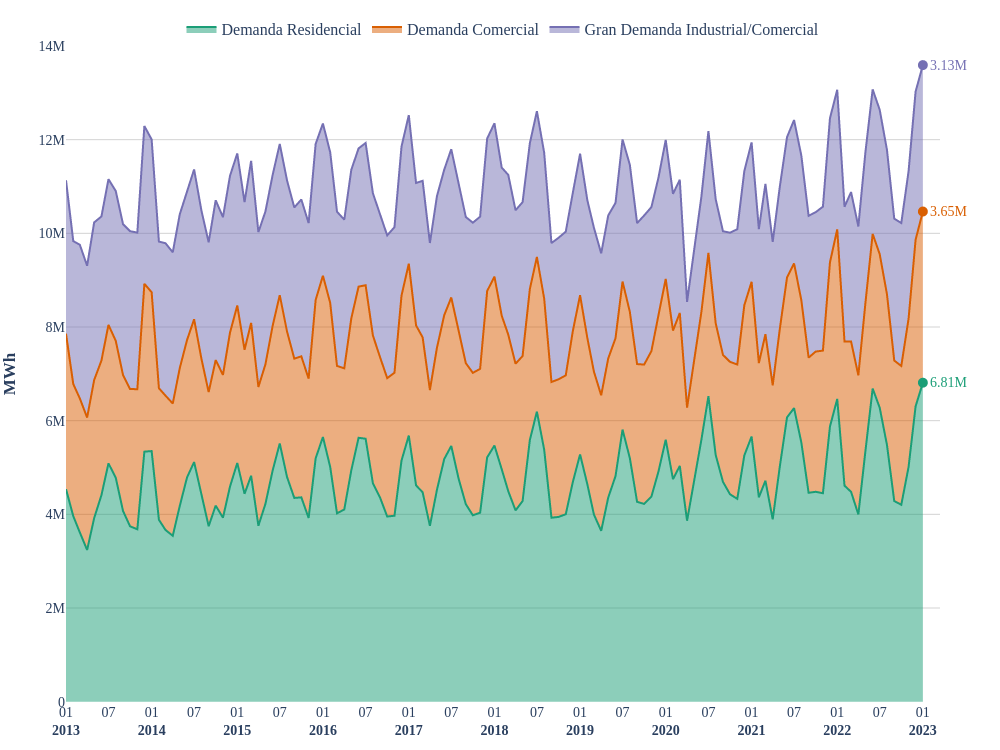

In [62]:
demanda_electrica.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [63]:
pio.write_image(demanda_electrica, "Figura Demanda Electrica.pdf", width=3*300, height=2.25*300)

### Figura: Precio monómico

Para el gráfico de la evolución del precio monómico, se selecciona el siguiente color.

In [64]:
color_precio = 'rgb(133, 92, 117)'

Se crea la figura `precio_monomico` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [65]:
precio_monomico = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `elec_update_layout` para modificar el aspecto de la figura en general.

In [66]:
precio_monomico.add_trace(
    go.Scatter(
      name = "Precio monómico",
      x = precio["Período"],
      y = precio["Precio monómico"],
      mode = 'lines',
      line = dict(
          color = color_precio,
          width = 2
      ),
    )
)

precio_monomico.add_trace(
    go.Scatter(
      showlegend = False,
      x = precio["Período"].tail(1),
      y = precio['Precio monómico'].tail(1),
      mode = 'markers',
      marker = dict(
          color = color_precio,
          size = 10
      )
    )
)

precio_monomico.add_annotation(
    x = precio["Período"][len(precio)-1],
    y = precio["Precio monómico"][-1:].values[0],
    text = str(round(precio["Precio monómico"][-1:].values[0], 1)),
    font = dict(color = color_precio),
    xanchor = "left",
    xshift = 5,
    yshift = 0,
    showarrow = False
    )

elec_update_layout(precio_monomico, None, precio, -60, 17000, "<b>ARS / MWh", 1)

A continuación, se exhibe la figura.

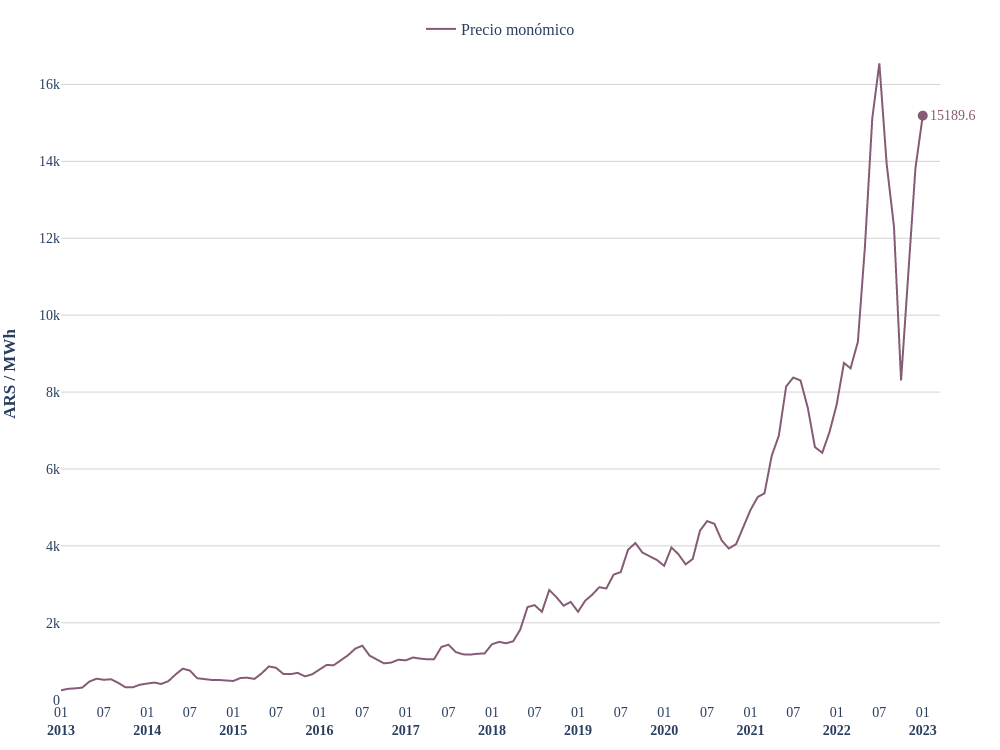

In [67]:
precio_monomico.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [68]:
pio.write_image(precio_monomico, "Figura Precio Monomico.pdf", width=3*300, height=2.25*300)

### Figura: Emisiones de CO<sub>2</sub> por GWh generado

Para el gráfico de la evolución del precio monómico, se selecciona el siguiente color.

In [69]:
color_emisiones = 'rgb(237, 173, 8)'

Se define como eje de abscisas a la conjunción entre las columnas "year" y "quarter".

In [70]:
x_emisiones = emisiones_por_GWh["year"].astype(str) + " - " + emisiones_por_GWh["quarter"].astype(str)

Se crea la figura `emisiones` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [71]:
emisiones = go.Figure()

Las especificaciones de la figura se encuentran en su argumento, y se hace uso de la función `elec_update_layout` para modificar el aspecto de la figura en general.

In [72]:
emisiones.add_trace(
    go.Scatter(
      name = "TCO\u2082 / GWh",
      x = x_emisiones,
      y = emisiones_por_GWh["TCO2 / GWh"],
      mode = 'lines',
      line = dict(
          color = color_emisiones,
          width = 2
      ),
    )
)

emisiones.add_trace(
    go.Scatter(
      showlegend = False,
      x = x_emisiones.tail(1),
      y = emisiones_por_GWh["TCO2 / GWh"].tail(1),
      mode = 'markers',
      marker = dict(
          color = color_emisiones,
          size = 10
      )
    )
)

emisiones.add_annotation(
    x = x_emisiones[len(emisiones_por_GWh)-1],
    y = emisiones_por_GWh["TCO2 / GWh"][-1:].values[0],
    text = str(round(emisiones_por_GWh["TCO2 / GWh"][-1:].values[0], 2)),
    font = dict(color = color_emisiones),
    xanchor = "left",
    xshift = 5,
    yshift = 0,
    showarrow = False
    )

elec_update_layout(emisiones, None, emisiones_por_GWh, 195, 400, "<b>TCO\u2082 / GWh", 0)

A continuación, se exhibe la figura.

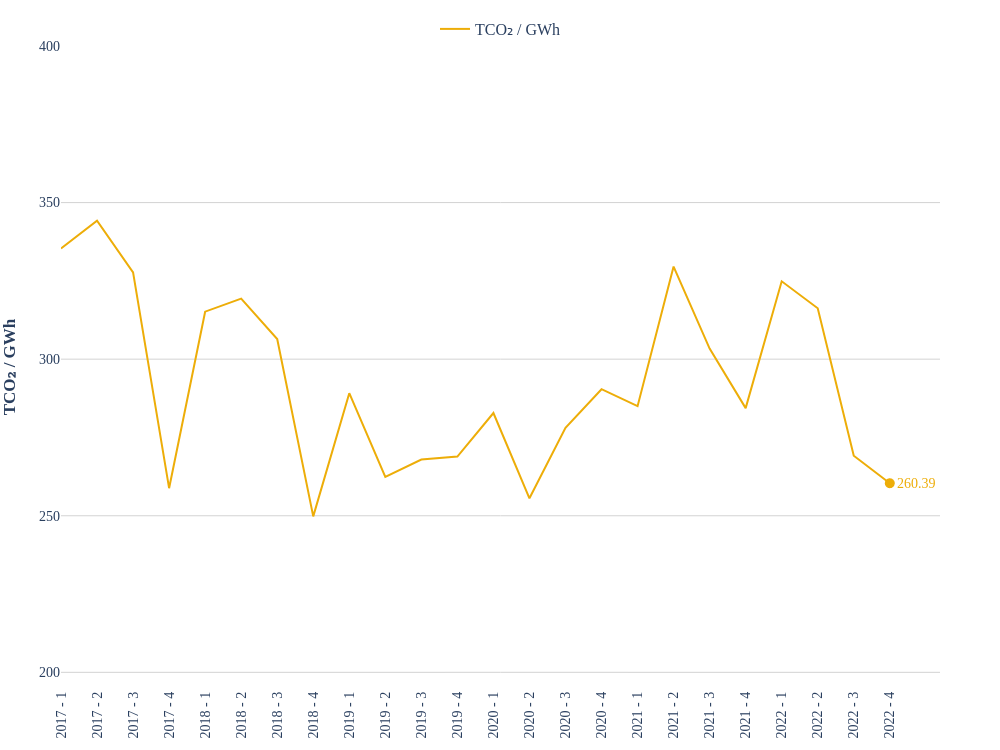

In [73]:
emisiones.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [74]:
pio.write_image(emisiones, "Figura Emisiones de CO2 por GWh Generado.pdf", width=3*300, height=2.25*300)